In [1]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from brainflow.data_filter import DataFilter, AggOperations, WaveletTypes, NoiseEstimationLevelTypes, WaveletExtensionTypes, ThresholdTypes, WaveletDenoisingTypes
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, NoiseTypes, DetrendOperations, WindowOperations
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds

In [2]:
mat_contents = sio.loadmat('Data/U001ai.mat')

In [3]:
sorted(mat_contents.keys())
eeg_electrodes = [i.item() for i in mat_contents['info']['label'].item()[0]]

In [4]:
eeg_data = np.array(mat_contents['eeg'])
eeg_data.shape


(15, 17792)

In [5]:
events = mat_contents['events'][:,1]
start_times = np.where(events==32779)[0]
end_times = np.where(events==32780)[0]
print("Finding the index of start and end times")
print(start_times)
print(end_times)

print()
print("Getting the EEG time index of start and end times")
event_index = mat_contents['events'][:,2]
start_index = event_index[start_times]
end_index = event_index[end_times]
print(start_index)
print(end_index)

Finding the index of start and end times
[ 2  5  8 11 14 17 20 23 26 29 32 35]
[ 3  6  9 12 15 18 21 24 27 30 33 36]

Getting the EEG time index of start and end times
[ 1030  2438  3846  5254  6662  8070  9478 10886 12294 13702 15110 16518]
[ 1670  3078  4486  5894  7302  8710 10118 11526 12934 14342 15750 17158]


In [6]:
eeg_epoch = []
processed_eeg = np.array([eeg_data[i].flatten() for i in range(14)])

# Average re-referencing
means = np.mean(processed_eeg, axis=0)
processed_eeg = processed_eeg - means


for i in range(14):
    DataFilter.perform_bandpass(processed_eeg[i], 128, 1.0, 48.0, 5, FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
    # DataFilter.perform_bandstop(eeg_data[i], 128, 58.0, 62.0, 2, FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)

print(len(processed_eeg[13]))

for i in range(len(start_index)):
    # Indexing 0:14 to remove last column (it is not eeg signal, just a status signal)
    eeg_epoch.append(processed_eeg[:, start_index[i]:end_index[i]])

eeg_epoch = np.array(eeg_epoch)
print(eeg_epoch.shape)

17792
(12, 14, 640)


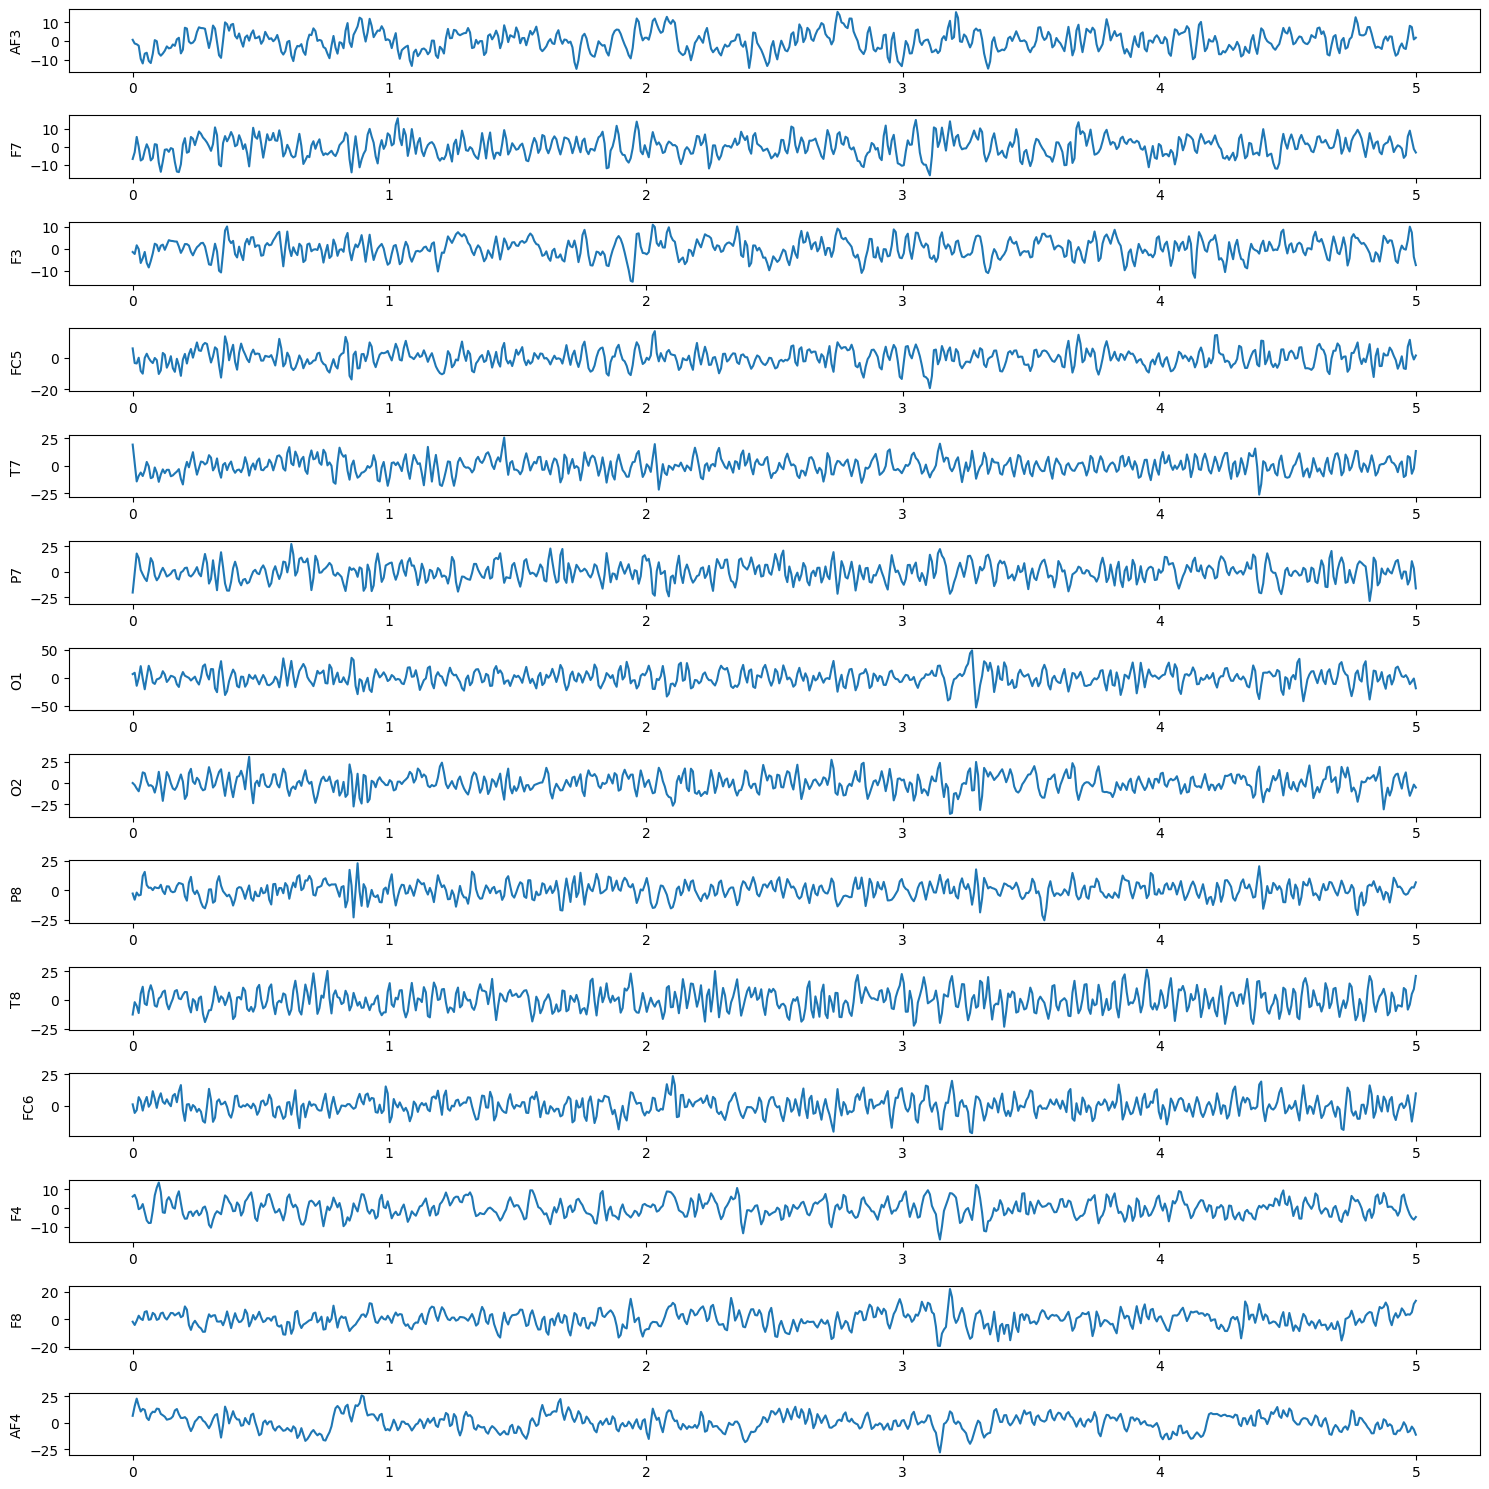

In [13]:
time = np.linspace(0, 5, 640)
fig, axs = plt.subplots(14, 1)
fig.set_figheight(15)
fig.set_figwidth(15)


for i in range(14):
    axs[i].plot(time, eeg_epoch[11][i])
    axs[i].set_ylabel(eeg_electrodes[i])

fig.tight_layout()
plt.show()

6.66Hz = 0.2933101786396639
7.5Hz = 0.5846989846544737
8.56z = 0.7812416836109785
10Hz = 1.0853606674870018
12Hz = 1.5922620818642714


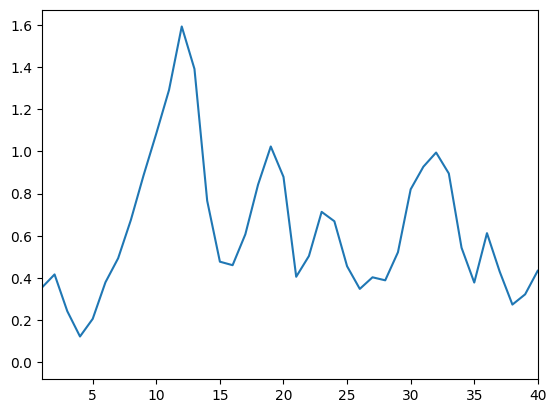

In [10]:
nfft = DataFilter.get_nearest_power_of_two(128)
target_psd_18hz = DataFilter.get_psd_welch((eeg_epoch[1][6]+eeg_epoch[1][7])/2, nfft, nfft // 2, 128, WindowOperations.BLACKMAN_HARRIS.value)

plt.plot(target_psd_18hz[1], target_psd_18hz[0])
plt.xlim(1, 40)
print(f'6.66Hz = {(target_psd_18hz[0][5] + target_psd_18hz[0][6]) / 2.0}') # 6.66
print(f'7.5Hz = {(target_psd_18hz[0][7] + target_psd_18hz[0][8]) / 2.0}') # 7.5
print(f'8.56z = {(target_psd_18hz[0][8] + target_psd_18hz[0][9]) / 2.0}') # 8.56
print(f'10Hz = {target_psd_18hz[0][10]}') # 10
print(f'12Hz = {target_psd_18hz[0][12]}') # 12